# Dataset

Mount to Google Drive and define the path where the dataset will be

In [ ]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)
dataset_folder_path = '/content/drive/My Drive/Colab Notebooks/ML Research/supervised-learning/intelligent-locker-system'

If the dataset used by **Gesture6** is not found in the `dataset_folder_path`, connect to Kaggle, download it, and clean it.

In [ ]:
%pip install opendatasets --upgrade --quiet
%pip install tensorflow

In [ ]:
'''
USERNAME = pedrovillegascelis
KEY = 90f5d28b93ddc0dd614439c87078db60
'''

import opendatasets as od
import os

CLASSES = ["01_palm", "02_l", "04_fist_moved", "06_index", "07_ok", "08_palm_moved"] # Gesture6.1
download_path = os.path.join(dataset_folder_path, "data")

if not os.path.exists(download_path):
  od.download("https://www.kaggle.com/datasets/gti-upm/leapgestrecog/data", data_dir=download_path)

else:
  print("Dataset already downloaded")

In [ ]:
import shutil # Imported for directory removal -> the os.remove() is intended to remove files and not directories

data_path = "/content/drive/My Drive/Colab Notebooks/ML Research/supervised-learning/intelligent-locker-system/data/leapgestrecog/leapGestRecog"
for subject in os.listdir(data_path):
  for gesture in os.listdir(os.path.join(data_path, subject)):
    if gesture not in CLASSES:
      shutil.rmtree(os.path.join(data_path, subject, gesture))

In case of running locally.

In [2]:
import os
import shutil # Imported for directory removal -> the os.remove() is intended to remove files and not directories

CLASSES = ["01_palm", "02_l", "04_fist_moved", "06_index", "07_ok", "08_palm_moved"] # Gesture6.1

data_path = "data/leapgestrecog/leapGestRecog"
for subject in os.listdir(data_path):
  for gesture in os.listdir(os.path.join(data_path, subject)):
    if gesture not in CLASSES:
      shutil.rmtree(os.path.join(data_path, subject, gesture))

# Gesture6 224x224

Import the **model** dependencies.

In [4]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Function to get the file_paths and labels.

In [5]:
def get_file_paths_and_labels(data_path):
  file_paths = []
  labels = []

  CLASSES = ["01_palm", "02_l", "04_fist_moved", "06_index", "07_ok", "08_palm_moved"]

  label_map = {}
  for counter, gesture in enumerate(CLASSES):
    label_map[gesture] = counter
    # {'01_palm': 0, '02_l': 1, '04_fist_moved': 2, '06_index': 3, '07_ok': 4, '08_palm_moved': 5}

  for subject in os.listdir(data_path):
    subject_path = os.path.join(data_path, subject)

    for gesture in os.listdir(subject_path):
      gesture_path = os.path.join(subject_path, gesture)

      for img_file in os.listdir(gesture_path):
        file_path = os.path.join(gesture_path, img_file)
        file_paths.append(file_path)
        labels.append(label_map[gesture])

  return file_paths, labels

Get the file paths and labels (colab).

In [ ]:
data_path = "/content/drive/My Drive/Colab Notebooks/ML Research/supervised-learning/intelligent-locker-system/data/leapgestrecog/leapGestRecog"
file_paths, labels = get_file_paths_and_labels(data_path)

# This is done here also, outside the previous function, just to have the "label_map" saved globally in case of a need.
CLASSES = ["01_palm", "02_l", "04_fist_moved", "06_index", "07_ok", "08_palm_moved"]
label_map = {}
for counter, gesture in enumerate(CLASSES):
  label_map[gesture] = counter

print("Label map:", label_map)

Get the file paths and labels (local).

In [6]:
data_path = "data/leapgestrecog/leapGestRecog"
file_paths, labels = get_file_paths_and_labels(data_path)

# This is done here also, outside the previous function, just to have the "label_map" saved globally in case of a need.
CLASSES = ["01_palm", "02_l", "04_fist_moved", "06_index", "07_ok", "08_palm_moved"]
label_map = {}
for counter, gesture in enumerate(CLASSES):
  label_map[gesture] = counter

print("Label map:", label_map)

Label map: {'01_palm': 0, '02_l': 1, '04_fist_moved': 2, '06_index': 3, '07_ok': 4, '08_palm_moved': 5}


Shuffle the data

In [7]:
'''
- "file_paths" is a list that contains the path to each image in the dataset
- "labels" is a list that contains the label of each image in the dataset

If file_paths is ['image1.jpg', 'image2.jpg'] and labels is [0, 1], after list(zip(...))
data will be [('image1.jpg', 0), ('image2.jpg', 1)].
'''
data = list(zip(file_paths, labels))

# Shuffle the data to improve training by randomizing
# the order of image-label pairs.
np.random.shuffle(data)

# Once the data has been randomized, zip(*data) undo the previous operations
# in the lists file_paths and labels to keep everything the same as before.
file_paths, labels = zip(*data)

Convert labels to string.

In [8]:
labels_str = [str(label) for label in labels]

Create a dataframe with file_paths and labels_str to finally create the ImageDataGenerator for training and validation.

In [9]:
# pd.DataFrame({column_name: values})

dataframe = pd.DataFrame({'filename': file_paths, 'class': labels_str})
dataframe

,filename,class
0,data/leapgestrecog/leapGestRecog\06\07_ok\fram...,4
1,data/leapgestrecog/leapGestRecog\01\06_index\f...,3
2,data/leapgestrecog/leapGestRecog\05\02_l\frame...,1
3,data/leapgestrecog/leapGestRecog\01\08_palm_mo...,5
4,data/leapgestrecog/leapGestRecog\06\02_l\frame...,1
...,...,...
11995,data/leapgestrecog/leapGestRecog\02\02_l\frame...,1
11996,data/leapgestrecog/leapGestRecog\05\06_index\f...,3
11997,data/leapgestrecog/leapGestRecog\01\06_index\f...,3
11998,data/leapgestrecog/leapGestRecog\09\08_palm_mo...,5


Parameters.

In [10]:
batch_size = 32
num_classes = 6
learning_rate = 0.001
epochs = 2
img_size = 224

Create ImageDataGenerator for training and validation.

In [11]:
datagen = ImageDataGenerator(
    rescale=1/255.0,            # Normalization
    # zoom_range=0.2,             # Data Aug.
    # width_shift_range=0.2,      # Data Aug.
    # height_shift_range=0.2,     # Data Aug.
    validation_split=0.2        # 20% of the data for validation
)

train_generator = datagen.flow_from_dataframe(
    dataframe=dataframe,
    x_col='filename',
    y_col='class',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=dataframe,
    x_col='filename',
    y_col='class',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 9600 validated image filenames belonging to 6 classes.
Found 2400 validated image filenames belonging to 6 classes.


Define the model.

In [12]:
model = Sequential()

model.add(Input(shape=(img_size, img_size, 3)))
model.add(Conv2D(filters=8, kernel_size=(3,3)))
model.add(Activation('relu'))

model.add(Conv2D(filters=8, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=16, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 8)    │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 220, 220, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 110, 110, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 108, 108, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,972,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,974,846 (22.79 MB)

 Trainable params: 5,974,846 (22.79 MB)

 Non-trainable params: 0 (0.00 B)

Define EarlyStopping before training.

*`EarlyStopping` is a Keras callback used to stop model training early if performance on a monitored metric, like validation loss (`val_loss`), stops improving. With `patience=3`, training stops if the metric doesn't improve for 3 consecutive epochs. The `restore_best_weights=True` option ensures the model retains the best weights found during training. This approach helps prevent overfitting, saves computational resources, and ensures better generalization on unseen data. It's particularly useful for optimizing training time while maintaining model quality.*

In [14]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

Train the model with early stopping

In [15]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

c:\Users\pablo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 78s 251ms/step - accuracy: 0.7685 - loss: 0.7213 - val_accuracy: 0.9954 - val_loss: 0.0234
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 72s 239ms/step - accuracy: 0.9972 - loss: 0.0087 - val_accuracy: 0.9967 - val_loss: 0.0098


In [17]:
history.history

{'accuracy': [0.9131249785423279, 0.9962499737739563],
 'loss': [0.2787262201309204, 0.010173418559134007],
 'val_accuracy': [0.9954166412353516, 0.996666669845581],
 'val_loss': [0.023387426510453224, 0.009793403558433056]}

Plot the training history.

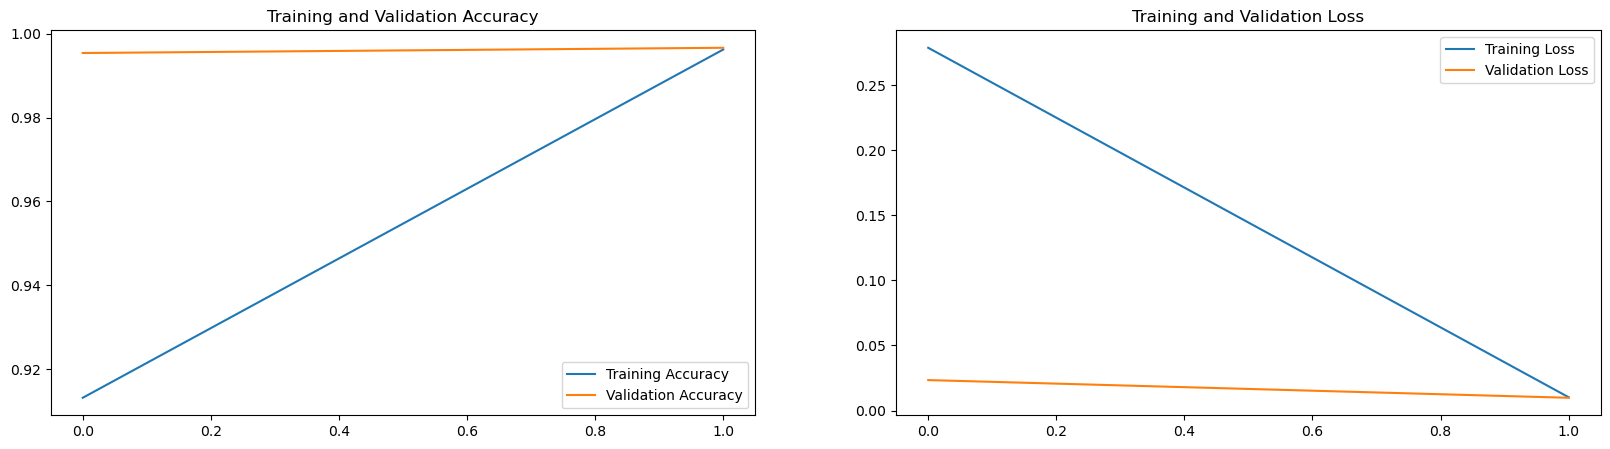

In [18]:
def plot_training_history(history):
  training_accuracy = history.history['accuracy']
  training_loss = history.history['loss']

  validation_accuracy = history.history['val_accuracy']
  validation_loss = history.history['val_loss']

  epochs_range = range(len(training_accuracy))

  # Main figure size (20,5)
  plt.figure(figsize=(20,5))

  # First subplot (Accuracy)
  plt.subplot(1,2,1) # plt.subplot(n_rows, n_cols, pos)
  plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
  plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  # Second subplot (Loss)
  plt.subplot(1,2,2)
  plt.plot(epochs_range, training_loss, label='Training Loss')
  plt.plot(epochs_range, validation_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

plot_training_history(history)

Evaluate the model.

In [19]:
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {validation_loss}")
print(f"Validation Accuracy: {validation_accuracy}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.9970 - loss: 0.0086
Validation Loss: 0.009793401695787907
Validation Accuracy: 0.996666669845581


Save the model (colab).

In [ ]:
model_path = "/content/drive/My Drive/Colab Notebooks/ML Research/supervised-learning/intelligent-locker-system"
model.save(os.path.join(model_path, 'Gesture6_11MB.h5'))

Save the model (local).

In [23]:
model_path = "C:/Users/pablo/Desktop/Gesture6/Gesture6/models"
model.save(os.path.join(model_path, 'Gesture6_11MB_99ACC.h5'))

# Gesture6 96x96

Reshape the original images from 224x224 to 96x96. This creates a new dataset called `data_reshaped` (colab).

In [ ]:
import os
from PIL import Image

data_path = "/content/drive/My Drive/Colab Notebooks/ML Research/supervised-learning/intelligent-locker-system/data/leapgestrecog/leapGestRecog"
data_reshaped_path = "/content/drive/My Drive/Colab Notebooks/ML Research/supervised-learning/intelligent-locker-system/data_reshaped"

# MKDIR if data_reshaped is not found
os.makedirs(data_reshaped_path, exist_ok=True)

for subject in os.listdir(data_path):
    subject_reshaped_path = os.path.join(data_reshaped_path, subject)
    os.makedirs(subject_reshaped_path, exist_ok=True)

    for gesture in os.listdir(os.path.join(data_path, subject)):
        gesture_reshaped_path = os.path.join(subject_reshaped_path, gesture)
        os.makedirs(gesture_reshaped_path, exist_ok=True)

        for img_file in os.listdir(os.path.join(data_path, subject, gesture)):
            img_path = os.path.join(data_path, subject, gesture, img_file)
            img_reshaped_path = os.path.join(gesture_reshaped_path, img_file)

            img = Image.open(img_path)
            img = img.resize((80, 80))
            img.save(img_reshaped_path)

print("The 96x96 version of the original images were saved in:", data_reshaped_path)

Reshape the original images from 224x224 to 96x96. This creates a new dataset called `data_reshaped` (local).

In [ ]:
import os
from PIL import Image

data_path = "data/leapgestrecog/leapGestRecog"
data_reshaped_path = "data_reshaped"

# MKDIR if data_reshaped is not found
os.makedirs(data_reshaped_path, exist_ok=True)

for subject in os.listdir(data_path):
    subject_reshaped_path = os.path.join(data_reshaped_path, subject)
    os.makedirs(subject_reshaped_path, exist_ok=True)

    for gesture in os.listdir(os.path.join(data_path, subject)):
        gesture_reshaped_path = os.path.join(subject_reshaped_path, gesture)
        os.makedirs(gesture_reshaped_path, exist_ok=True)

        for img_file in os.listdir(os.path.join(data_path, subject, gesture)):
            img_path = os.path.join(data_path, subject, gesture, img_file)
            img_reshaped_path = os.path.join(gesture_reshaped_path, img_file)

            img = Image.open(img_path)
            img = img.resize((96, 96))
            img.save(img_reshaped_path)

print("The 96x96 version of the original images were saved in:", data_reshaped_path)